# General Overview

* ### **This is the [titanic project](https://www.kaggle.com/competitions/titanic) from Kaggle. The task essentially is to understand the dataset, use feature engineering to make it employable for a model that predicts whether a passenger is a possible survivor of the incident.**


* ### **The meaning of all columns of the dataset may not be obvious. For a helpful guide on how to interpret them, visit [description](https://data.world/nrippner/titanic-disaster-dataset).**


In [170]:
import numpy as np # linear algebra
import pandas as pd # dataset processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Feature Engineering and Dataset Overview

In [171]:
# Loading dataset
train_dataset = pd.read_csv("/kaggle/input/titanic/train.csv")
test_dataset = pd.read_csv("/kaggle/input/titanic/test.csv")

#Passenger IDs
passenger_ID_train = train_dataset['PassengerId']
passenger_ID_test = test_dataset['PassengerId']

# displaying the dataset
train_dataset.sample(5)
passenger_ID_train


0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

### Visualization of features or columns

In [172]:
# general stats
train_dataset.describe()
test_dataset.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 1.1 Inspecting missing values

In [173]:
# function to find missing vals
def find_missing_vals(df:pd.DataFrame):    
    for column in df.columns:        
        total_entries = df[column].shape[0]
        missing_entries = df[column].isnull().sum()
        print(f"% missing {column} ({type((df[column][0]))}):{(missing_entries / total_entries) * 100}")
    

In [174]:
print("*"*50)
print("Training dataset Missing Info")
find_missing_vals(train_dataset)
print("*"*50)
print("Test dataset Missing Info")
find_missing_vals(test_dataset)
print("*"*50)

**************************************************
Training dataset Missing Info
% missing PassengerId (<class 'numpy.int64'>):0.0
% missing Survived (<class 'numpy.int64'>):0.0
% missing Pclass (<class 'numpy.int64'>):0.0
% missing Name (<class 'str'>):0.0
% missing Sex (<class 'str'>):0.0
% missing Age (<class 'numpy.float64'>):19.865319865319865
% missing SibSp (<class 'numpy.int64'>):0.0
% missing Parch (<class 'numpy.int64'>):0.0
% missing Ticket (<class 'str'>):0.0
% missing Fare (<class 'numpy.float64'>):0.0
% missing Cabin (<class 'float'>):77.10437710437711
% missing Embarked (<class 'str'>):0.22446689113355783
**************************************************
Test dataset Missing Info
% missing PassengerId (<class 'numpy.int64'>):0.0
% missing Pclass (<class 'numpy.int64'>):0.0
% missing Name (<class 'str'>):0.0
% missing Sex (<class 'str'>):0.0
% missing Age (<class 'numpy.float64'>):20.574162679425836
% missing SibSp (<class 'numpy.int64'>):0.0
% missing Parch (<class 'num

#### Observation: Majority of the **_cabin and age_** information is missing, let's see what we can do to still extract meaningful features from these entries

### 1.1.1 Mystery of the cabin numbers

In [175]:
unique_cabin_entries = np.unique(train_dataset['Cabin'].tolist())
cabin_info = [cabin[0] for cabin in unique_cabin_entries if cabin != 'nan']
print(np.unique(cabin_info))

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T']


#### Observation: The cabins seem to start with a specific letter, which we could now use as an ***identifier*** for the 'Cabin' feature. We will use only these indentifiers for the cabin column and map them to numbers.The missing entries will be replaced by 0.

In [176]:
# mapping identifiers to a number
mapping = {'A':1, 'B':2 ,'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'nan':0}

# looping over train and test data
datasets = [train_dataset, test_dataset]
for dataset in datasets:
    for idx, cabin_num in enumerate(dataset['Cabin']):

        if str(cabin_num) == 'nan':
            identifier = 0
        else:
            identifier = int(mapping[cabin_num[0]])

        dataset.loc[idx, 'Cabin'] = identifier



#### 1.1.2 Investigating missing age entries and adding additional features

* Using the 'SibSp' (sibling/spouse) and the 'parch' features, we will find which passengers were travelling with families

In [177]:
from sklearn.impute import SimpleImputer

# common interpolation tool for substituting missing entries with averages from that column
imputer = SimpleImputer(strategy='mean') 

for dataset in datasets:
    # Age, Embarked and Fare info
    dataset['Age'] = imputer.fit_transform(dataset['Age'].values.reshape(-1, 1)) #  nan entries replaced with averages
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])  # replacing missing embarked values with entries that are the most common in that column
    dataset['Fare'] = (dataset['Fare'].fillna(0)).astype(int)  # nan entries relpaced with zero
    
    # Family info
    # reminder:Number of Parents/Children Aboard (see first cell of the notebook)
    dataset['isAlone'] = (dataset['SibSp'] + dataset['Parch'] == 0).astype(int)
    dataset['isFamily'] = (dataset['SibSp'] + dataset['Parch'] > 0).astype(int)    
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train_dataset.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isAlone,isFamily,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7,0,S,0,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71,3,C,0,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7,0,S,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53,3,S,0,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8,0,S,1,0,1
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8,0,Q,1,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51,5,S,1,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21,0,S,0,1,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11,0,S,0,1,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30,0,C,0,1,2


#### Observation: 
* The 'Name' feature needs an identifier, perhaps we can use the title of a passenger for it, i.e., Mr, Mrs., etc.
* Once this is done, all entries with categorical values will be mapped to integers.


In [178]:
# format of the names: last_name, title. first_name, ...

for dataset in datasets:
    name_identifiers =  dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand = False) # all titles or identifiers
    
    # prepare for mapping
    keys = np.unique(name_identifiers.values) # unique titles
    values = np.arange(np.unique(name_identifiers.values).shape[0]) # numbers ranging from 0 to number of unique identifiers

    # mapping
    mapping = {key: value for key, value in zip(keys, values)}
    print(mapping)
    dataset['Name'] = name_identifiers
    
    for idx, name in enumerate(dataset['Name']):
        dataset.loc[idx, 'Name'] = mapping[name]
        
    dataset.rename(columns = {"Name": "Title"}, inplace = True)


{'Capt': 0, 'Col': 1, 'Countess': 2, 'Don': 3, 'Dr': 4, 'Jonkheer': 5, 'Lady': 6, 'Major': 7, 'Master': 8, 'Miss': 9, 'Mlle': 10, 'Mme': 11, 'Mr': 12, 'Mrs': 13, 'Ms': 14, 'Rev': 15, 'Sir': 16}
{'Col': 0, 'Dona': 1, 'Dr': 2, 'Master': 3, 'Miss': 4, 'Mr': 5, 'Mrs': 6, 'Ms': 7, 'Rev': 8}


In [179]:
train_dataset.head()

,PassengerId,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isAlone,isFamily,FamilySize
0,1,0,3,12,male,22.0,1,0,A/5 21171,7,0,S,0,1,2
1,2,1,1,13,female,38.0,1,0,PC 17599,71,3,C,0,1,2
2,3,1,3,9,female,26.0,0,0,STON/O2. 3101282,7,0,S,1,0,1
3,4,1,1,13,female,35.0,1,0,113803,53,3,S,0,1,2
4,5,0,3,12,male,35.0,0,0,373450,8,0,S,1,0,1


In [180]:
# categorical mapping for remaining features:
# Lets also divide the ages into specific groups! Maybe this helps with recognizing patterns
train_dataset['AgeGroup'] = pd.cut(train_dataset['Age'], bins=[0, 12, 18, 60, np.inf], labels=['Child', 'Teenager', 'Adult', 'Senior'])
test_dataset['AgeGroup'] =  pd.cut(test_dataset['Age'], bins=[0, 12, 18, 60, np.inf], labels=['Child', 'Teenager', 'Adult', 'Senior'])

mapping_age_sex_embarked = {
    'Sex': {'male': 0, 'female': 1},
    'Embarked': {'S': 0, 'C': 1, 'Q': 2},
    'AgeGroup': {'Child': 1, 'Teenager': 2, 'Adult': 3, 'Senior': 4}
}

def mapping_function(mapping_dict: dict, datasets):
    
    for data in datasets:
        
        for feature, value in mapping_dict.items():
            print(feature, value)
            data[feature] = data[feature].map(value)
            
mapping_function(mapping_dict = mapping_age_sex_embarked, datasets = datasets)

Sex {'male': 0, 'female': 1}
Embarked {'S': 0, 'C': 1, 'Q': 2}
AgeGroup {'Child': 1, 'Teenager': 2, 'Adult': 3, 'Senior': 4}
Sex {'male': 0, 'female': 1}
Embarked {'S': 0, 'C': 1, 'Q': 2}
AgeGroup {'Child': 1, 'Teenager': 2, 'Adult': 3, 'Senior': 4}


In [181]:
# dropping unneccessary columns
for dataset in datasets:
    dataset.drop(columns = ['Ticket', 'Age'], inplace = True)
    
train_dataset.head()

,PassengerId,Survived,Pclass,Title,Sex,SibSp,Parch,Fare,Cabin,Embarked,isAlone,isFamily,FamilySize,AgeGroup
0,1,0,3,12,0,1,0,7,0,0,0,1,2,3
1,2,1,1,13,1,1,0,71,3,1,0,1,2,3
2,3,1,3,9,1,0,0,7,0,0,1,0,1,3
3,4,1,1,13,1,1,0,53,3,0,0,1,2,3
4,5,0,3,12,0,0,0,8,0,0,1,0,1,3


In [182]:
from sklearn.preprocessing import StandardScaler

def normalize_data(data):
    scaler = StandardScaler()

    for i in range(len(data)):
        # apply scaling to the whole data and update the original dataframe
        data[i][:] = scaler.fit_transform(data[i])

    return data

data = normalize_data([train_dataset, test_dataset])

In [183]:
# forcing datatype to be the same across columns/features
for dataset in datasets:
    for column in dataset.columns:
        dataset[column] = dataset[column].astype(np.float64)

#### Training data

In [185]:
# Replacing passenger ID column with original values- we do not want to normalize them or use them as features
train_dataset['PassengerId'] = passenger_ID_train
test_dataset['PassengerId'] = passenger_ID_test

# features used
features = train_dataset.columns[2:].tolist()
features


['Pclass',
 'Title',
 'Sex',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'Embarked',
 'isAlone',
 'isFamily',
 'FamilySize',
 'AgeGroup']

In [186]:
# split the train_ds into features and target
X = train_dataset.drop(columns=['Survived','PassengerId'])
y = train_dataset['Survived'].astype(int)

from sklearn.model_selection import train_test_split

# # split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
X.head()

,Pclass,Title,Sex,SibSp,Parch,Fare,Cabin,Embarked,isAlone,isFamily,FamilySize,AgeGroup
0,0.827377,0.417887,-0.737695,0.432793,-0.473674,-0.498948,-0.488461,-0.568837,-1.231645,1.231645,0.059160,0.343449
1,-1.566107,0.954397,1.355574,0.432793,-0.473674,0.789405,1.398325,1.005181,-1.231645,1.231645,0.059160,0.343449
2,0.827377,-1.191641,1.355574,-0.474545,-0.473674,-0.498948,-0.488461,-0.568837,0.811922,-0.811922,-0.560975,0.343449
3,-1.566107,0.954397,1.355574,0.432793,-0.473674,0.427056,1.398325,-0.568837,-1.231645,1.231645,0.059160,0.343449
4,0.827377,0.417887,-0.737695,-0.474545,-0.473674,-0.478817,-0.488461,-0.568837,0.811922,-0.811922,-0.560975,0.343449


In [188]:
# apply different classifier with kfold and cross validation score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from xgboost import XGBClassifier

# create a list of classifiers
classifiers = [RandomForestClassifier, DecisionTreeClassifier, SVC, LogisticRegression, KNeighborsClassifier, GaussianNB, XGBClassifier, LDA]

# create a list of classifiers names
classifiers_names = ['RandomForestClassifier', 'DecisionTreeClassifier', 'SVC', 'LogisticRegression', 'KNeighborsClassifier', 'GaussianNB', 'XGBClassifier', 'LDA']

# create a list of classifiers scores
classifiers_scores = []

# loop over each classifier and calculate the cross validation score
for classifier, name in zip(classifiers, classifiers_names):
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    model = classifier()
    cv_score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    classifiers_scores.append(cv_score.mean())

# create a dataframe of classifiers and their scores
classifiers_df = pd.DataFrame({'Classifier': classifiers_names, 'Score': classifiers_scores})
classifiers_df

,Classifier,Score
0,RandomForestClassifier,0.823783
1,DecisionTreeClassifier,0.805830
2,SVC,0.831660
3,LogisticRegression,0.805818
4,KNeighborsClassifier,0.823820
5,GaussianNB,0.794594
6,XGBClassifier,0.820437
7,LDA,0.796816


In [189]:
# Let's find the top three classifiers and investigate if any hyperparameter tuning can improve their classification scores!
classifiers_df.sort_values('Score', ascending = False)[:4]

,Classifier,Score
2,SVC,0.831660
4,KNeighborsClassifier,0.823820
0,RandomForestClassifier,0.823783
6,XGBClassifier,0.820437


In [190]:
# checking for SVC, KNeighborsClassifier, LogisticRegression

# function to return the best parameters and scores achieved
def grid_search_for_classifier(parameter_grid: dict, classifier_name: str):
    
    if classifier_name == 'SVC':
        classifier = SVC(random_state = 42)
        
    elif classifier_name == 'KNN':
        classifier = KNeighborsClassifier(algorithm='auto')
        
    elif classifier_name == 'LR':
        classifier = LogisticRegression(random_state = 42)
    
    elif classifier_name == 'RF':
        classifier = RandomForestClassifier(random_state = 42)
        
    elif classifier_name  == 'LDA':
        classifier = LDA()
        
    
    # Setup the RandomizedSearchCV instance
    random_search = GridSearchCV(estimator=classifier, param_grid=parameter_grid, cv=3, verbose=0, n_jobs=-1)

    # Fit the RandomizedSearchCV instance to the data
    random_search.fit(X, y)

    # Print the best parameters and the corresponding score
#     print(f"Best parameters for {classifier_name}: {random_search.best_params_}")
#     print(f"Best score for {classifier_name}: {random_search.best_score_}")

    # Retrieve the best estimator
    best_classifier_est = random_search.best_estimator_
#     print(f"best fit accuracy for {classifier_name}",best_classifier_est.score(X, y))
    
    return best_classifier_est


In [191]:
# defining parameter grids

# Logistic Regression
param_grid_LR = {
    'C': np.logspace(-4, 4, 10),  # Regularization parameter (inverse of L2 penalty)
    'penalty': ['l1', 'l2'],  # Penalty type (L1 or L2 regularization)
    'solver': ['liblinear', 'lbfgs']  # Solver algorithm
    }

# Support Vector Classifier
param_grid_SVC = {
  'C': [0.1, 1, 10, 100, 1000], # Regularization parameter (inverse of L2 penalty)
  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], # Coefficient of the RBF kernel function
  'kernel': ['rbf'], # Kernel function type (only 'rbf' in this grid)
  'degree': [1, 2, 3, 4] # Degree of the polynomial kernel function (ignored for 'rbf' kernel)
}

# K nearest neighbors
param_grid_KNN =  {
  'n_neighbors': (1, 10, 1),  # Number of neighbors to consider (exhaustive search)
  'leaf_size': (20, 40, 1),    # Leaf size for ball tree (ignored for BallTree)
  'p': (1, 2),                 # Minkowski distance power parameter (ignored for other metrics)
  'weights': ('uniform', 'distance'),  # Weighting scheme for neighbors
  'metric': ('minkowski', 'chebyshev') # Distance metric used for neighbor selection
}

# Random Forest
param_grid_RF = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# LDA
param_grid_LDA = {
  'tol': [1e-1, 1e-2, 1e-3],  # Tolerance for singular values or coefficients
  'shrinkage': [None, 'auto'],  # Shrinking method (None for no shrinkage)
}

best_estimator_LR = grid_search_for_classifier(parameter_grid = param_grid_LR, classifier_name = 'LR')

best_estimator_SVC = grid_search_for_classifier(parameter_grid = param_grid_SVC, classifier_name = 'SVC')

best_estimator_KNN = grid_search_for_classifier(parameter_grid = param_grid_KNN, classifier_name = 'KNN')

best_estimator_RF = grid_search_for_classifier(parameter_grid = param_grid_RF, classifier_name = 'RF')

best_estimator_LDA = grid_search_for_classifier(parameter_grid = param_grid_LDA, classifier_name = 'LDA')


#### Observation


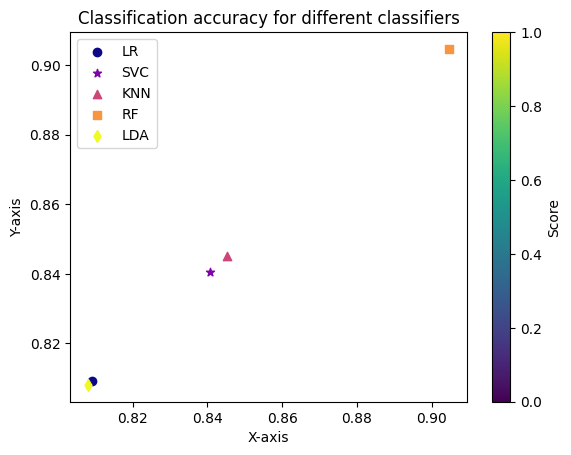

In [192]:
scores = np.array([best_estimator_LR.score(X, y), best_estimator_SVC.score(X, y),
                   best_estimator_KNN.score(X, y) ,best_estimator_RF.score(X, y), best_estimator_LDA.score(X, y)])

conditions = ['LR', 'SVC', 'KNN', 'RF', 'LDA']
markers = ['o', '*', '^', 's', 'd']
cmap = plt.cm.plasma  # You can choose other colormaps like 'plasma', 'coolwarm'
colors = cmap(np.linspace(0, 1, len(scores)))

# Create the scatter plot
plt.figure()
for i in range(len(conditions)):
  plt.scatter(scores[i], scores[i], label=conditions[i], marker=markers[i], c=colors[i])

# Add legend and labels
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Classification accuracy for different classifiers')
plt.colorbar(label='Score')  # Add colorbar to represent scores

plt.show()

In [130]:
test_dataset.head()

,PassengerId,Pclass,Title,Sex,SibSp,Parch,Fare,Cabin,Embarked,isAlone,isFamily,FamilySize,AgeGroup
0,892,0.873482,0.155072,-0.755929,-0.499470,-0.400248,-0.503540,-0.476399,2.243165,0.807573,-0.807573,-0.553443,0.292908
1,893,0.873482,1.292265,1.322876,0.616992,-0.400248,-0.503540,-0.476399,-0.677841,-1.238278,1.238278,0.105643,0.292908
2,894,-0.315819,0.155072,-0.755929,-0.499470,-0.400248,-0.467701,-0.476399,2.243165,0.807573,-0.807573,-0.553443,2.093428
3,895,0.873482,0.155072,-0.755929,-0.499470,-0.400248,-0.485620,-0.476399,-0.677841,0.807573,-0.807573,-0.553443,0.292908
4,896,0.873482,1.292265,1.322876,0.616992,0.619896,-0.413943,-0.476399,-0.677841,-1.238278,1.238278,0.764728,0.292908


In [132]:
# Submitting predictions
print("features used for training", features)
test_dataset.head()
# test_predictions  = best_estimator_RF.predict(X_test)

# creating final output
# output = pd.DataFrame({'PassengerId': test_dataset.PassengerId, 'Survived': test_predictions})
# output.to_csv('submission.csv', index=False)
# print("Submission saved!")

features used for training ['Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'isAlone', 'isFamily', 'FamilySize', 'AgeGroup']


,PassengerId,Pclass,Title,Sex,SibSp,Parch,Fare,Cabin,Embarked,isAlone,isFamily,FamilySize,AgeGroup
0,892,0.873482,0.155072,-0.755929,-0.499470,-0.400248,-0.503540,-0.476399,2.243165,0.807573,-0.807573,-0.553443,0.292908
1,893,0.873482,1.292265,1.322876,0.616992,-0.400248,-0.503540,-0.476399,-0.677841,-1.238278,1.238278,0.105643,0.292908
2,894,-0.315819,0.155072,-0.755929,-0.499470,-0.400248,-0.467701,-0.476399,2.243165,0.807573,-0.807573,-0.553443,2.093428
3,895,0.873482,0.155072,-0.755929,-0.499470,-0.400248,-0.485620,-0.476399,-0.677841,0.807573,-0.807573,-0.553443,0.292908
4,896,0.873482,1.292265,1.322876,0.616992,0.619896,-0.413943,-0.476399,-0.677841,-1.238278,1.238278,0.764728,0.292908


In [194]:
X_test = test_dataset.drop(columns = 'PassengerId')
predictions  = best_estimator_RF.predict(X_test)


In [196]:
output = pd.DataFrame({'PassengerId': test_dataset.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
